In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, subdir, filenames in tqdm(os.walk('/kaggle/input'), total = 3):
    for filename in filenames:
        filepath = (os.path.join(dirname, filename))
        print("loading from", filepath)
        if "images" in filename:
            images = np.load(filepath, allow_pickle = True)
        elif "masks" in filename:
            masks = np.load(filepath, allow_pickle = True)
        else:
            labels = np.load(filepath, allow_pickle = True)
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  0%|          | 0/3 [00:00<?, ?it/s]

loading from /kaggle/input/brain-tumor/brain_tumor_dataset/images.npy
loading from /kaggle/input/brain-tumor/brain_tumor_dataset/labels.npy
loading from /kaggle/input/brain-tumor/brain_tumor_dataset/masks.npy


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


<h3>Exploring data</h3>

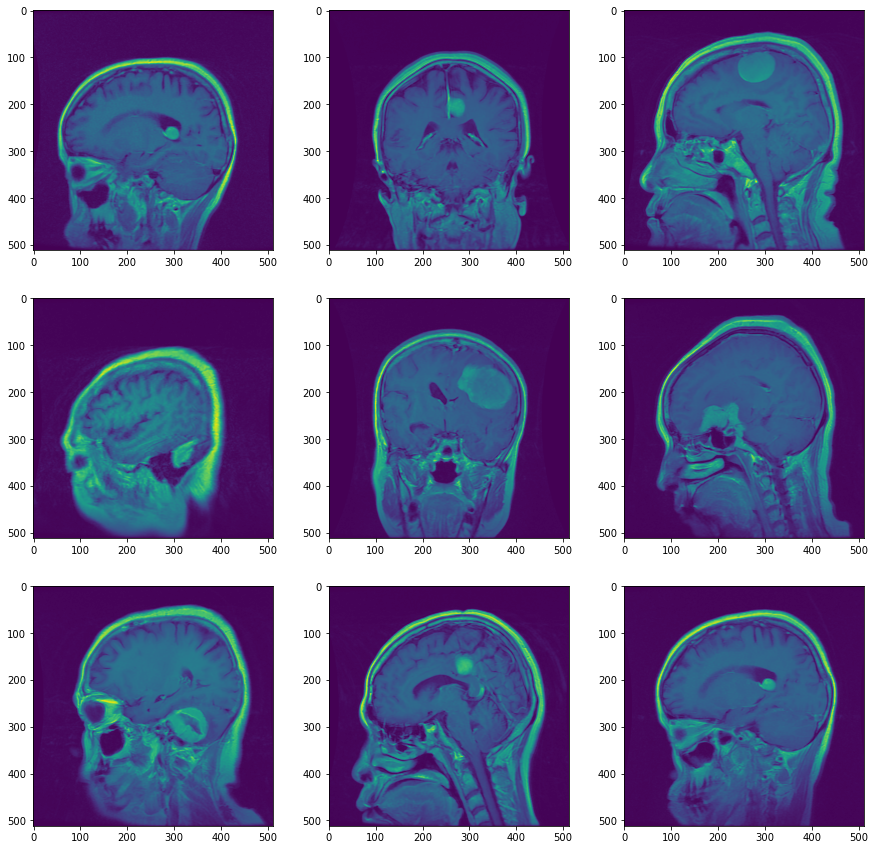

In [2]:
sample_number = 9
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(sample_number):
    subplot = ax[int(i//3), int(i%3)]
    subplot.imshow(images[i])
plt.show()

In [3]:
trainset = np.column_stack((images, masks, labels))
print(trainset.shape)
# 3064x3x512x512
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(trainset, test_size = 0.1)
trainset, validset = train_test_split(trainset, test_size = 0.05)
print('size of trainset, testset and validset is',len(trainset), len(testset), len(validset))

(3064, 3)
size of trainset, testset and validset is 2619 307 138


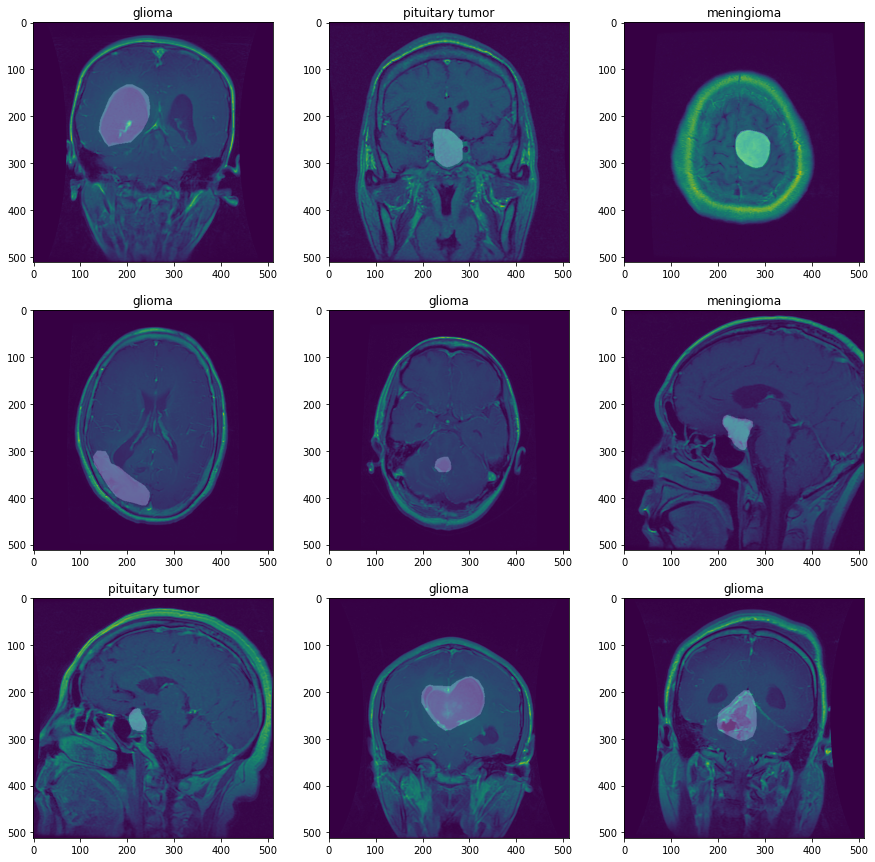

In [4]:
classes = ["meningioma", "glioma", "pituitary tumor"] 

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(sample_number):
    subplot = ax[int(i//3), int(i%3)]
    subplot.imshow(trainset[i][0])
    subplot.set_title(classes[trainset[i][2]-1])
    subplot.imshow(trainset[i][1], cmap='gray', alpha=0.2)
plt.show()

In [5]:
import torch
import torch.nn as nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 32
workers = 4
print("device available: ", device)

device available:  cuda:0


<h3>Helper functions</h3>

In [6]:
import torchvision.transforms as transform
import torchvision.transforms.functional as TF
import random
from PIL import Image

random.seed(123)

class Resize(object):
    def __init__(self, size=216):
        self.size = size
    
    def __call__(self, sample):
        image, mask, label = sample
        image = TF.resize(image, size=(self.size, self.size), interpolation=Image.NEAREST)
        mask = TF.resize(mask, size = (self.size, self.size), interpolation=Image.NEAREST)
        return image, mask, label
    

class toPIL(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, mask, label = sample
        image = TF.to_pil_image(image.astype(np.float32))
        mask = TF.to_pil_image(mask.astype(np.float32))
        return image, mask, label

    
class toTensor(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, mask, label = sample
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask, label
    
    
class Rotate(object):
    def __init__(self, p):
        self.p = p
        
    def __call__(self, sample):
        image, mask, label = sample
        if random.random() < self.p:
            angle = random.randint(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)
        return image, mask, label
    
    
class Flip(object):
    def __init__(self, p):
        self.p = p
        
    def __call__(self, sample):
        image, mask, label = sample
        if random.random() < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        return image, mask, label
    

class Crop(object):
    def __init__(self, p):
        self.p = p
    
    def __call__(self, sample):
        image, mask, label = sample
        if random.random() < self.p:
            size = image.size[1]
            crop_size = random.randint(int(size*0.5), size)
            image = TF.center_crop(image, output_size=crop_size)
            mask = TF.center_crop(mask, output_size=crop_size)
        return image, mask, label
    
    
class Padding(object):
    def __init__(self, size):
        super(Padding, self).__init__()
        self.size = size
        
    def __call__(self, sample):
        image, mask, label = sample
        w, h = image.size
        if (w < self.size):
            image = TF.pad(image, padding = (self.size-w)//2, fill=0)
            mask = TF.pad(mask, padding = (self.size-w)//2, fill=0)
        return image, mask, label
    
class ZoomOut(object):
    def __init__(self, p):
        super(ZoomOut, self).__init__()
        self.p = p
        
    def __call__(self, sample):
        image, mask, label = sample
        w, h = image.size
        if (random.random() < self.p):
            resize = Resize(random.randint(int(0.5*w), int(.95*w)))
            pad = Padding(w)
            sample = resize(sample)
            sample = pad(sample)
        return sample
    
    
def toNumpy(sample):
    image, mask, label = sample
    image = np.array(image)
    mask = np.array(mask)
    return image, mask, label


def normalize(sample):
    image, mask, label = sample
    m, s = np.mean(image), np.std(image)
    image = (image - m)/s
    return image, mask, label


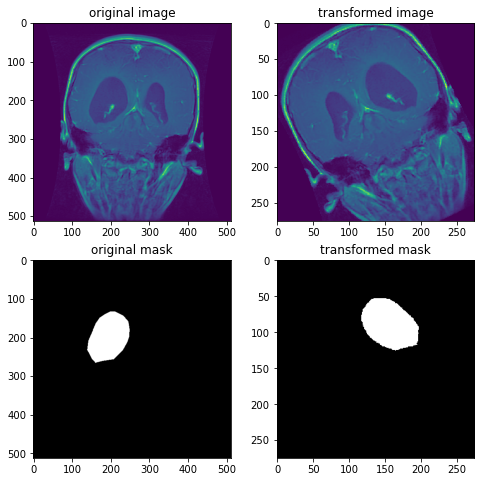

In [7]:
def getTransform(rotate, crop, flip, zoom):
    return transform.Compose([
        Rotate(rotate),
        ZoomOut(zoom),
        Crop(crop),
        Flip(flip),
    ])

func = toPIL()
testimg = func(trainset[0])
trans = getTransform(rotate=1, crop=1, flip=1, zoom=1 )
test = trans(testimg)
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(np.array(testimg[0]))
ax[0, 0].set_title("original image")
ax[0, 1].imshow(np.array(test[0]))
ax[0, 1].set_title('transformed image')
ax[1, 0].imshow(np.array(testimg[1]), cmap='gray')
ax[1, 0].set_title('original mask')
ax[1, 1].imshow(np.array(test[1]), cmap='gray')
ax[1, 1].set_title('transformed mask')
plt.show()

<h3>Dataset class and DataLoader</h3>

In [8]:
from torch.utils.data import Dataset, DataLoader
input_size = 128
class MRIDataset(Dataset):
    def __init__(self, data, train=True, transform=None):
        self.data = data
        self.transform = transform
        self.train = train
        self.data = [normalize(i) for i in self.data]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        sample = self.data[i]
        
        to_pil = toPIL()
        sample = to_pil(sample)
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        resize_func = Resize(input_size)
        sample = resize_func(sample)
        sample = toNumpy(sample)
        
        image, mask, label = sample
        target_label = np.zeros((3, 1, 1))
        target_label[label-1, 0, 0] = 1
        label = target_label
                
        image = torch.from_numpy(image.astype(np.float32))
        mask = torch.from_numpy(mask.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))
        
        image = torch.unsqueeze(image, dim = 0)
        mask = torch.unsqueeze(mask, dim = 0)

        
        return image, mask, label
    
trainset = MRIDataset(trainset, transform = getTransform(.8, .8, .8, .7)) 
testset  = MRIDataset(testset)
validset = MRIDataset(validset)

In [9]:
def getDataLoader(dataset, batch = batch_size):
    dataloader = DataLoader(
        dataset, 
        batch_size = batch,
        shuffle = True,
        num_workers = workers
    )
    return dataloader

testLoader  = getDataLoader(testset)
trainLoader = getDataLoader(trainset)
validLoader = getDataLoader(validset)

<h3>Define model</h3>

In [10]:
from collections import OrderedDict

in_features = 128

class Unet(nn.Module):
    def __init__(self, in_channels = 1, out_channel = 1, init_features=in_features):
        super(Unet, self).__init__()
        self.in_channels = 1
        self.out_channels = 3
        self.init_features = init_features
        
        self.encoder1 = self.__block__(inchannels = in_channels,
                                      outchannels = init_features)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.encoder2 = self.__block__(inchannels = init_features,
                                      outchannels = 2*init_features)
        self.encoder3 = self.__block__(inchannels = 2*init_features,
                                      outchannels = 4*init_features)
        self.encoder4 = self.__block__(inchannels = 4*init_features,
                                      outchannels = 8*init_features)
        self.bottle   = self.__block__(inchannels = 8*init_features,
                                      outchannels = 16*init_features)
        self.upconv4  = nn.ConvTranspose2d(
            in_channels = 16*init_features, out_channels = 8 * init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder4 = self.__block__(inchannels = 16*init_features,
                                      outchannels = 8*init_features)
        self.upconv3  = nn.ConvTranspose2d(
            in_channels = 8 * init_features, out_channels = 4 * init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder3 = self.__block__(inchannels = 8*init_features,
                                      outchannels = 4*init_features)
        self.upconv2 = nn.ConvTranspose2d(
            in_channels = 4 * init_features, out_channels = 2 * init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder2 = self.__block__(inchannels = 4*init_features,
                                      outchannels = 2*init_features)
        self.upconv1 = nn.ConvTranspose2d(
            in_channels = 2 * init_features, out_channels = init_features,
            kernel_size = 2, stride = 2
        )
        self.decoder1 = self.__block__(inchannels = 2*init_features, 
                                      outchannels = init_features)
        self.final = nn.Conv2d(in_channels = init_features, out_channels = out_channel, kernel_size=1)
        
        self.sub_final = self.__fc__(16*init_features)
        
            
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottom = self.bottle(self.pool(enc4))
        pred_label = self.sub_final(bottom)
        
        dec = self.upconv4(bottom)
        dec = torch.cat((dec, enc4), dim=1)
        dec = self.decoder4(dec)
        
        dec = self.upconv3(dec)
        dec = torch.cat((dec, enc3), dim=1)
        dec = self.decoder3(dec)
        
        dec = self.upconv2(dec)
        dec = torch.cat((dec, enc2), dim=1)
        dec = self.decoder2(dec)
        
        dec = self.upconv1(dec)
        dec = torch.cat((dec, enc1), dim=1)
        dec = self.decoder1(dec)
        
        dec = self.final(dec)
        
        return torch.sigmoid(dec), pred_label
        
    class __block__(nn.Module):
        def __init__(self, inchannels, outchannels):
            super().__init__()
   
            self.conv = nn.Sequential( 
                nn.Conv2d(
                    in_channels=inchannels,
                    out_channels=outchannels,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=outchannels)
            )
            self.block = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=outchannels,
                    out_channels=outchannels,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=outchannels)
            )
            self.relu = nn.ReLU()
            
        
        def forward(self, x):
            x = self.conv(x)
            return self.relu(self.block(x) + x)

    class __fc__(nn.Module):
        def __init__(self, in_features):
            super().__init__()
            self.block = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_features,
                    out_channels=in_features//2,
                    kernel_size=2,
                    stride=2,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=in_features//2),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=in_features//2,
                    out_channels=in_features//4,
                    kernel_size=2,
                    stride=2,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=in_features//4),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels=in_features//4,
                    out_channels=3,
                    kernel_size=2,
                    stride=2,
                    bias=False,
                ),
                nn.Softmax(dim=1)
            )
            
        def forward(self,x) :
            return self.block(x)

<h3>Loss function</h3>

In [11]:
def dice_coef(y_pred, y_true):
    smooth = 1e-3
    numerator =   (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

def dice_loss(y_pred, y_true):
    return 1. - dice_coef(y_pred, y_true)

class dice(nn.Module):
    def __init__(self):
        super(dice, self).__init__()
        
    def forward(self, y_pred, y_true):
        return dice_loss(y_pred, y_true)

def dsc(y_pred, y_true):
    smooth = 1e-3
    y_pred, y_true = torch.round(y_pred), torch.round(y_true)
    numerator = (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

class bce_dice_loss(nn.Module):
    def __init__(self):
        super(bce_dice_loss, self).__init__()
        self.loss = nn.BCELoss()
        
    def forward(self, mask_pred, label_pred, mask_true, label_true):
        return dice_loss(mask_pred, mask_true) + self.loss(label_pred.squeeze(), label_true.squeeze())

<h3>Training model</h3>

In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

unet = Unet()
unet.to(device)
adam = optim.Adam(unet.parameters(), lr=1e-3)
scheduler = StepLR(adam, step_size=20, gamma=0.1)
epochs = 50
loss_func = bce_dice_loss()
train_loss_history = []
valid_loss_history = []
best_valid = 1e3

for epoc in range(epochs):
    print('------')
    print('epoch:', epoc + 1,'/',epochs)
    train_loss = []
    valid_loss = []
    
    # train 
    unet.train()
    pbar = tqdm(trainLoader, total=int(len(trainset)//batch_size),position=0, leave=True)
    
    for data, mask, label in pbar:
        data, mask, label = data.to(device), mask.to(device), label.to(device)
        mask_pred, label_pred = unet(data)
        adam.zero_grad()
        loss = loss_func(mask_pred, label_pred, mask, label)
        train_loss.append(loss.item())
        loss.backward()
        adam.step()
    train_loss_history.append(np.mean(train_loss))
    
    
    # valid 
    with torch.no_grad():
        unet.eval()
        for data, mask, label in validLoader:
            data, mask, label = data.to(device), mask.to(device), label.to(device)
            mask_pred, label_pred = unet(data)
            loss = loss_func(mask_pred, label_pred, mask, label)
            valid_loss.append(loss.item())

    valid_loss_history.append(np.mean(valid_loss))
    print('train loss:', train_loss_history[-1])
    print('valid loss:', valid_loss_history[-1])
    
    # save better model
    if (best_valid > valid_loss_history[-1]):
        best_valid = valid_loss_history[-1]
        torch.save(unet.state_dict(), os.path.join('./', 'unet.pt'))
        
    scheduler.step()

    
print('best validation loss:', best_valid)

# load model
state_dict = torch.load(os.path.join('./', 'unet.pt'))
unet.load_state_dict(state_dict);


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 1 / 50


82it [00:56,  1.45it/s]


train loss: 1.2818129019039433
valid loss: 1.2178767919540405


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 2 / 50


82it [00:54,  1.49it/s]


train loss: 1.0036920265453617
valid loss: 0.9695218086242676


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 3 / 50


82it [00:55,  1.47it/s]


train loss: 0.8616454724858447
valid loss: 0.8395908236503601


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 4 / 50


82it [00:55,  1.48it/s]


train loss: 0.7391086744099129
valid loss: 0.8046722412109375


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 5 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.7453245716850933
valid loss: 0.9011942505836487
------
epoch: 6 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.6828238775090474
valid loss: 0.8196627020835876
------
epoch: 7 / 50


82it [00:54,  1.50it/s]


train loss: 0.6197653223828572
valid loss: 0.6863925337791443


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 8 / 50


82it [00:54,  1.49it/s]


train loss: 0.5993884772789188
valid loss: 0.6354327738285065


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 9 / 50


82it [00:55,  1.49it/s]


train loss: 0.5412219424800175
valid loss: 0.4546215355396271


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 10 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.5039646320226716
valid loss: 0.6918975949287415
------
epoch: 11 / 50


82it [00:54,  1.50it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.4787211076515477
valid loss: 0.5178743302822113
------
epoch: 12 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.4368981148411588
valid loss: 0.5680517315864563
------
epoch: 13 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.410903827446263
valid loss: 0.6870634317398071
------
epoch: 14 / 50


82it [00:54,  1.49it/s]


train loss: 0.39881626752818505
valid loss: 0.44523854851722716


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 15 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.37807886774947
valid loss: 0.5160276353359222
------
epoch: 16 / 50


82it [00:54,  1.50it/s]


train loss: 0.36670381612167124
valid loss: 0.3236838847398758


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 17 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.3732566684484482
valid loss: 0.36151490807533265
------
epoch: 18 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.3631346948990008
valid loss: 0.3877315014600754
------
epoch: 19 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.3631473785129989
valid loss: 0.3441676676273346
------
epoch: 20 / 50


82it [00:55,  1.48it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.3471028548551769
valid loss: 0.3598362624645233
------
epoch: 21 / 50


82it [00:54,  1.49it/s]


train loss: 0.28967279922671435
valid loss: 0.24212145209312438


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 22 / 50


82it [00:54,  1.49it/s]


train loss: 0.2706831183011939
valid loss: 0.23519176244735718


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 23 / 50


82it [00:54,  1.49it/s]


train loss: 0.27142848674117065
valid loss: 0.22951371669769288


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 24 / 50


82it [00:54,  1.50it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.2653251802775918
valid loss: 0.23049607127904892
------
epoch: 25 / 50


82it [00:54,  1.50it/s]


train loss: 0.2514943505932645
valid loss: 0.2147878512740135


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 26 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.25253946461328647
valid loss: 0.26106437742710115
------
epoch: 27 / 50


82it [00:54,  1.50it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.2528195846371534
valid loss: 0.22896688878536225
------
epoch: 28 / 50


82it [00:55,  1.48it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.251377498231283
valid loss: 0.23353331685066223
------
epoch: 29 / 50


82it [00:55,  1.48it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.2553560404879291
valid loss: 0.2283932626247406
------
epoch: 30 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.25101293496242383
valid loss: 0.23197610974311828
------
epoch: 31 / 50


82it [00:54,  1.50it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.24068616003524967
valid loss: 0.216209277510643
------
epoch: 32 / 50


82it [00:54,  1.49it/s]


train loss: 0.24359507513482395
valid loss: 0.21148189902305603


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 33 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.23276173523286495
valid loss: 0.29107960164546964
------
epoch: 34 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.23880629241466522
valid loss: 0.23367430567741393
------
epoch: 35 / 50


82it [00:54,  1.50it/s]


train loss: 0.23598862502996515
valid loss: 0.21037950217723847


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 36 / 50


82it [00:54,  1.49it/s]


train loss: 0.22263136451564183
valid loss: 0.20348130464553832


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 37 / 50


82it [00:55,  1.49it/s]


train loss: 0.22953195188467096
valid loss: 0.19911892116069793


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 38 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.2324933525992603
valid loss: 0.24045434296131135
------
epoch: 39 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.22967400474519264
valid loss: 0.21608249545097352
------
epoch: 40 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.21847232594722654
valid loss: 0.22161499857902528
------
epoch: 41 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.221171644857017
valid loss: 0.2048327773809433
------
epoch: 42 / 50


82it [00:55,  1.48it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.21024921154830514
valid loss: 0.20825731456279756
------
epoch: 43 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.20621738473816617
valid loss: 0.20968354642391204
------
epoch: 44 / 50


82it [00:54,  1.49it/s]


train loss: 0.20994382160829334
valid loss: 0.18429035395383836


  0%|          | 0/81 [00:00<?, ?it/s]

------
epoch: 45 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.20981661266669993
valid loss: 0.20495715737342834
------
epoch: 46 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.21100347089331326
valid loss: 0.19939719140529633
------
epoch: 47 / 50


82it [00:55,  1.47it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.21438949155371365
valid loss: 0.20107658207416534
------
epoch: 48 / 50


82it [00:54,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.20684028880261793
valid loss: 0.21003379821777343
------
epoch: 49 / 50


82it [00:55,  1.49it/s]
  0%|          | 0/81 [00:00<?, ?it/s]

train loss: 0.20537052140003298
valid loss: 0.19584149718284607
------
epoch: 50 / 50


82it [00:54,  1.49it/s]


train loss: 0.21213019757372578
valid loss: 0.19843650758266448
best validation loss: 0.18429035395383836


In [13]:
#save progess
from numpy import savetxt
savetxt('./train_loss_history.csv', train_loss_history, delimiter=',')
savetxt('./valid_loss_history.csv', valid_loss_history, delimiter=',')

<h3>plot training progress</h3>

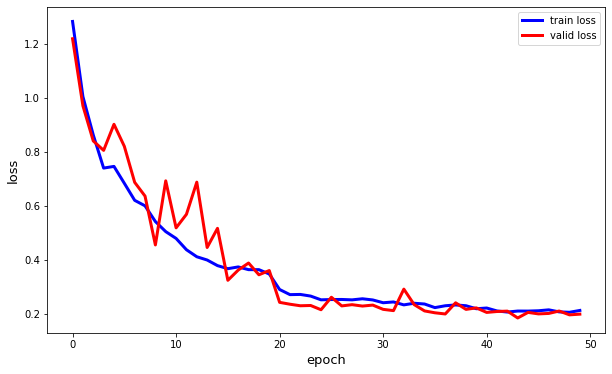

In [14]:
x = np.arange(epochs)

fig = plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_history, label='train loss', lw=3, color='blue')
plt.plot(x, valid_loss_history, label='valid loss', lw=3, color='red')
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend()
plt.show()

<h3>testing model</h3>

In [15]:
unet.eval()


with torch.no_grad():
    test_loss_dsc = []
    for img, mask, label in testLoader:
        img, mask, label = img.to(device), mask.to(device), label.to(device)
        mask_pred, label_pred = unet(img)
        class_pred = torch.argmax(label_pred, dim=1)
        class_true = torch.argmax(label, dim=1)
        correct = torch.flatten(class_pred == class_true)
        
        
        mask_pred = torch.unsqueeze(torch.unsqueeze(torch.unsqueeze(correct, dim=1),dim=2), dim=3) * mask_pred
        loss = dsc(mask_pred, mask)
        test_loss_dsc.append(loss.item())
        
        
    print("test's dsc:", np.mean(test_loss_dsc))

test's dsc: 0.7960800588130951


<h3>Showing some results</h3>

In [16]:
def showRes(img, mask_pred, label_pred, mask, label):
    img, mask = img.detach().detach().cpu().numpy(), mask.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    mask_pred, label_pred = mask_pred.detach().cpu().numpy(), label_pred.cpu().numpy()
    mask_pred = np.round(mask_pred)
    label_pred = np.argmax(label_pred, axis=0)
    label_pred = label_pred.flatten()
    
    label = np.argmax(label, axis=0)
    label = label.flatten()
    
    
    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
    ax[0, 0].imshow(img[0])
    ax[0, 0].set_title('image')
    ax[0, 1].imshow(mask[0], cmap='gray')
    ax[0, 1].set_title('gt ' + classes[label[0]])
    
    ax[1, 0].imshow(img[0])
    ax[1, 0].set_title('image')
    ax[1, 1].imshow(mask_pred[0], cmap='gray')
    ax[1, 1].set_title('pred ' + classes[label_pred[0]])
 

In [17]:
def show_batch(img, pred, mask, lable):
    mask_pred, label_pred = pred
    for i in range(img.size()[0]):
        showRes(img[i], mask_pred[i], label_pred[i].squeeze(), mask[i], label[i].squeeze())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


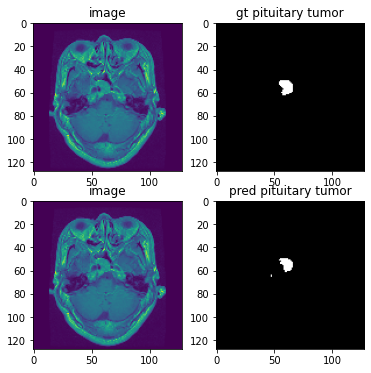

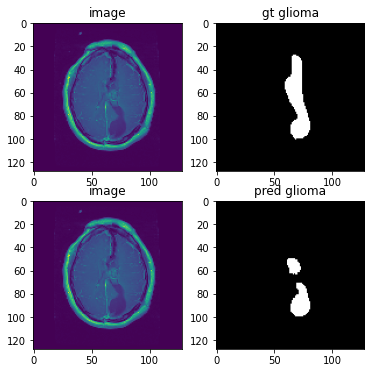

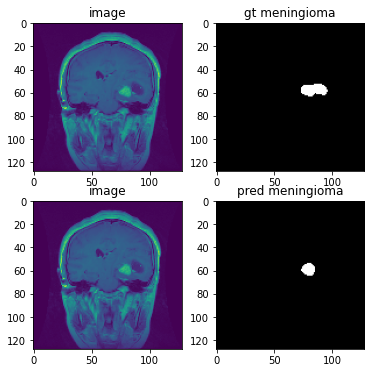

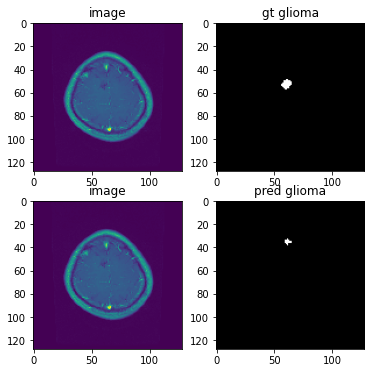

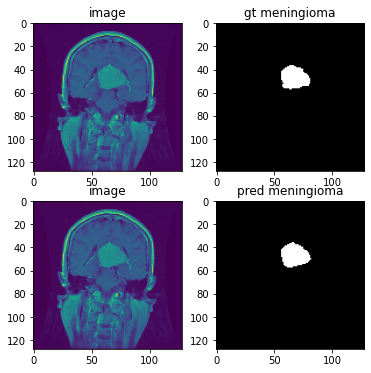

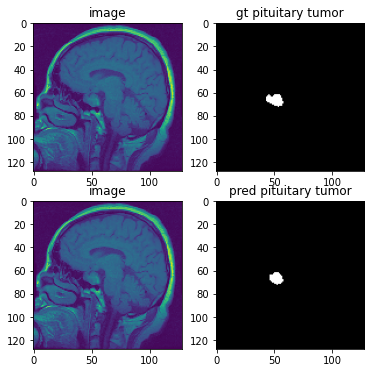

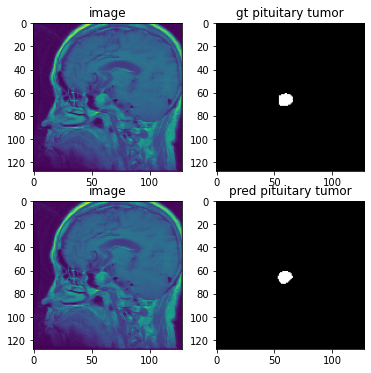

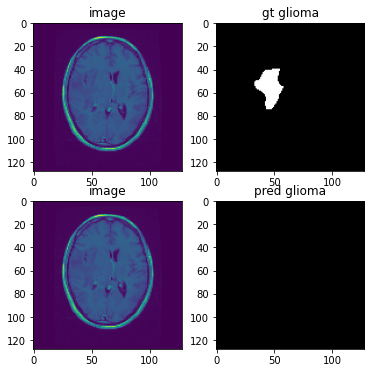

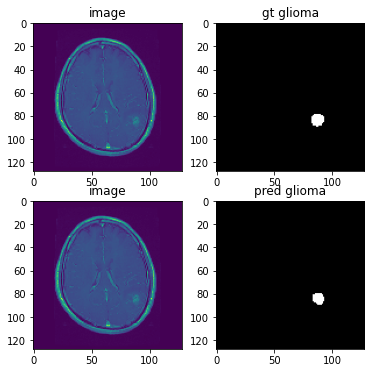

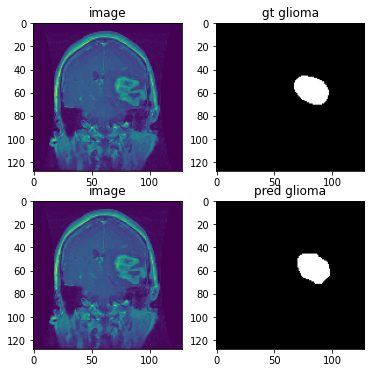

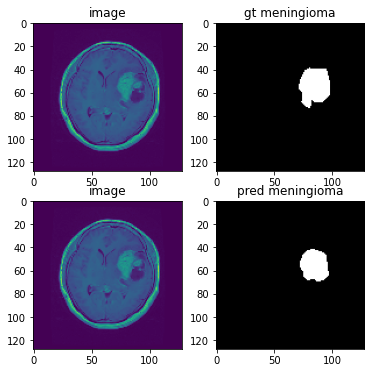

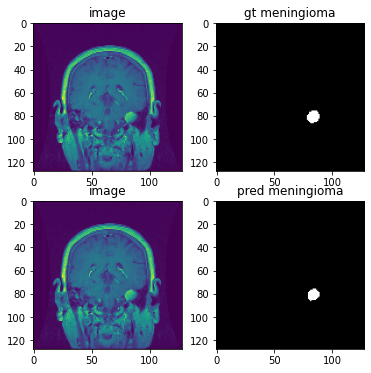

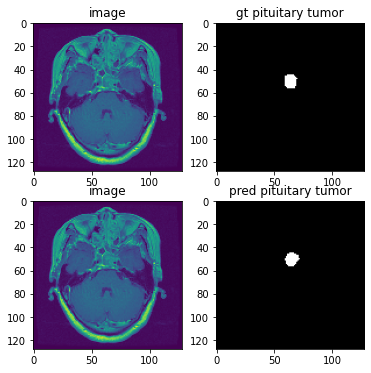

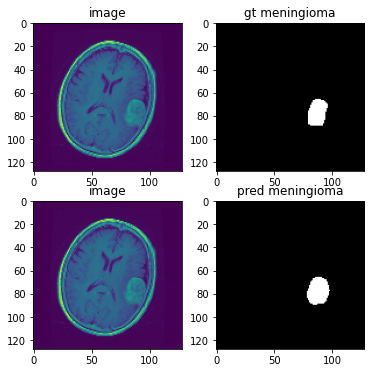

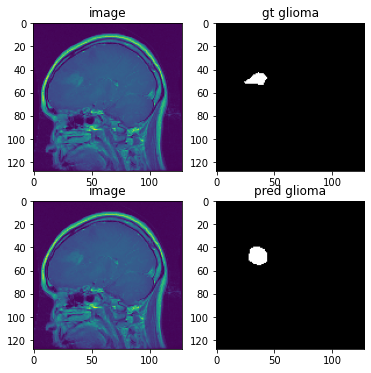

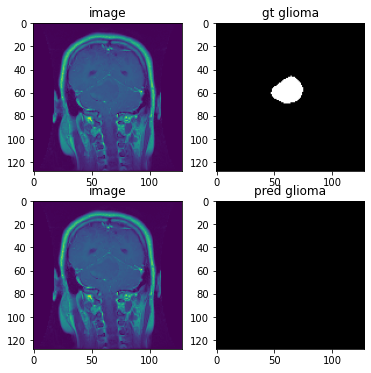

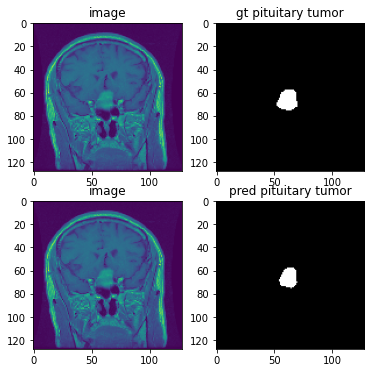

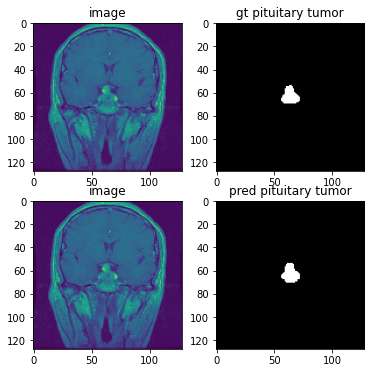

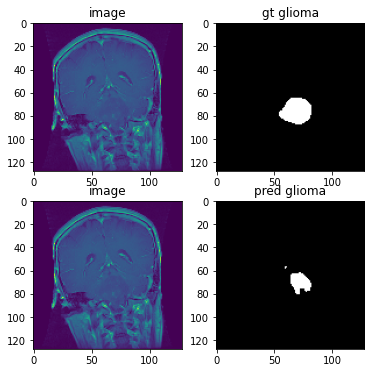

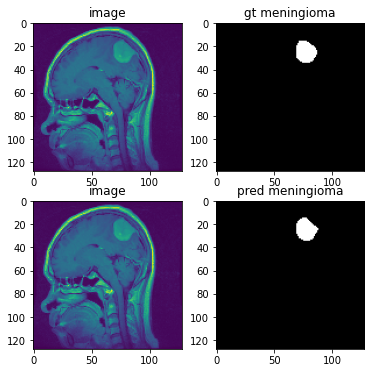

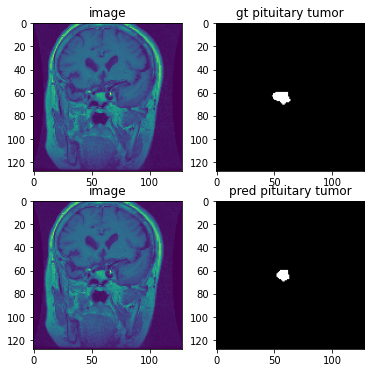

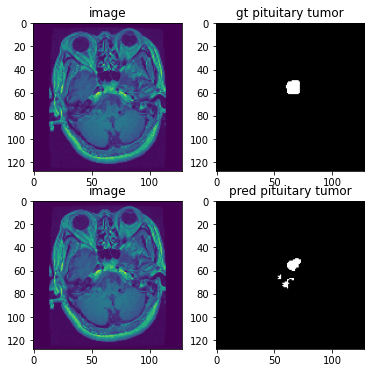

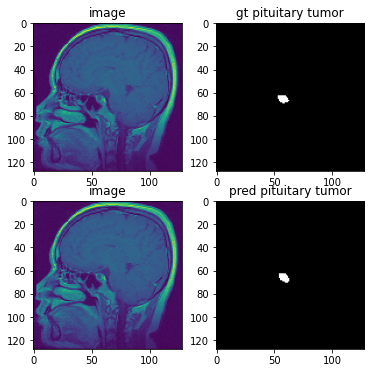

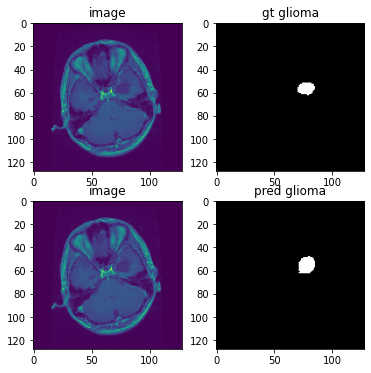

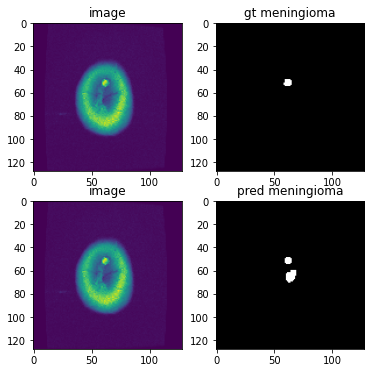

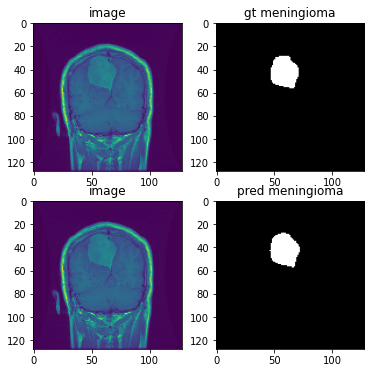

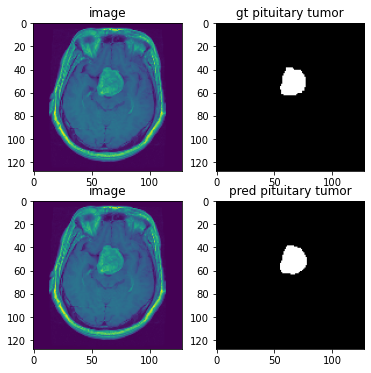

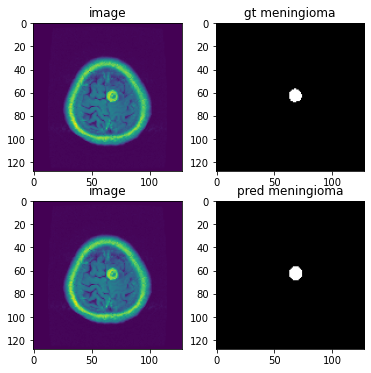

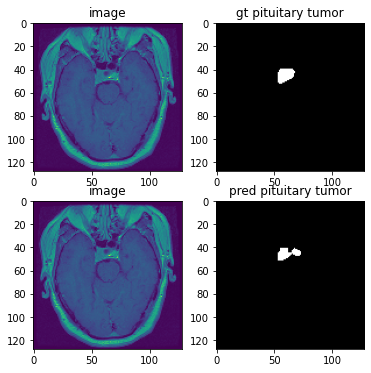

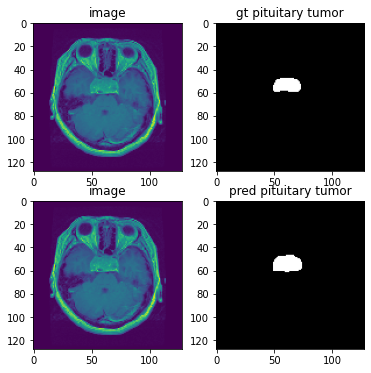

In [18]:
with torch.no_grad():
    for img, mask, label in testLoader:
        img, mask, label = img.to(device), mask.to(device), label.to(device)
        pred = unet(img)
        show_batch(img, pred, mask, label)
        break
        